In [1]:
###########
# Generic #
###########
from collections import Counter
import glob
import json
import os
import shutil
from pathlib import Path

########
# Libs #
########
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.io as io
from PIL import Image
from pycocotools.coco import COCO
from zipfile import ZipFile

###########
# Configs #
###########
SRC_DIR = Path.cwd().parent.parent
DATA_DIR = os.path.join(SRC_DIR, "data", "life3-aut0", "20220224_1032621")

%matplotlib inline

## Unzipping files

In [2]:
filepaths = glob.glob(os.path.join(DATA_DIR,"*"))
annot_dir_name = 'annotations'
annot_file_name = 'instances_default.json'
img_dir_name = 'images'

In [3]:
def unzip_files(filepaths, data_dir):
    """Unzips folder to get the images and annotations.
    
    Args:
        filepaths (str): list of file paths
        data_dir (str): data directory
    """

    for filepath in filepaths:
        folder_name = Path(filepath).stem
        with ZipFile(filepath, 'r') as zip:
            zip.extractall(path=os.path.join(data_dir, folder_name))
    print("All files unzipped")

unzip_files(filepaths, data_dir=DATA_DIR)

IsADirectoryError: [Errno 21] Is a directory: '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 36-55 revised'

## Processing of annotations

In [4]:
annot_files = []
for filepath in filepaths:
    if not filepath.endswith('.zip'):
        annot_path = os.path.join(filepath, annot_dir_name, annot_file_name)
    if Path(annot_path).exists():
        annot_files.append(annot_path)
print(annot_files)

['/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 36-55 revised/annotations/instances_default.json', '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 8-24 revised/annotations/instances_default.json', '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 8-24 revised/annotations/instances_default.json', '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 8-24 revised/annotations/instances_default.json', '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 25-35 revised/annotations/instances_default.json', '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 25-35 revised/annotations/instances_default.json', '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 56-75 revised/annotations/instances_default.json', '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 1-7 revised/a

In [5]:
annot_content_list = []
annot_count = 0
for a in annot_files:
    with open(a) as json_file:
        contents = json.load(json_file)
        annot_content_list.append(contents)
        contents_annot = contents['annotations']
        annot_count += len(contents_annot)
print(f'Number of annotation files: {len(annot_content_list)}')
print(f'Total number of annotations: {annot_count}')

Number of annotation files: 12
Total number of annotations: 35043


In [6]:
batch_num = 1
df_concat_list = []
for content in annot_content_list:
    print(f'\n=== DIRECTORY {batch_num} ===')
    content_images = content['images']
    print(f'Number of images: {len(content_images)}')
    df_images = pd.DataFrame(content_images)
    df_images.set_index('id', inplace=True)
    df_images.drop(labels=['license','flickr_url','coco_url','date_captured'], axis=1, inplace=True)
#     print(df_images.tail())
    
    content_cat = content['categories']
    df_cat = pd.DataFrame(content_cat)
    df_cat.rename(mapper={'name':'category_name'}, axis=1, inplace=True)
    df_cat.drop(labels=['supercategory'], axis=1, inplace=True)
#     print(df_cat)
    
    content_annot = content['annotations']
    print(f'Number of annotations: {len(content_annot)}')
    df_annot = pd.DataFrame(content_annot)
    df_annot.set_index('id', inplace=True)
    df_annot.drop(labels=['segmentation','iscrowd','attributes'], axis=1, inplace=True)
    print(df_annot.tail(10),"\n=====")
    
    final_df = df_annot.merge(df_images, left_on='image_id', right_on='id')
    final_df = final_df.merge(df_cat, left_on='category_id', right_on='id')
    final_df.drop(labels=['id'], axis=1, inplace=True)
    df_concat_list.append(final_df)
    batch_num += 1


=== DIRECTORY 1 ===
Number of images: 20
Number of annotations: 3030
      image_id  category_id      area                           bbox
id                                                                  
3021        20            1  432.0000   [601.46, 859.71, 21.6, 20.0]
3022        20            1  345.8700   [591.66, 875.91, 18.3, 18.9]
3023        20            1  634.9500   [395.01, 895.98, 24.9, 25.5]
3024        20            1  852.3900   [432.66, 948.32, 29.7, 28.7]
3025        20            1  621.7800   [401.76, 954.22, 24.1, 25.8]
3026        20            1  319.9200   [421.76, 970.62, 17.2, 18.6]
3027        20            1  307.9800   [228.62, 911.01, 17.4, 17.7]
3028        20            1  583.2000   [102.88, 860.08, 24.0, 24.3]
3029        20            1  356.1720     [0.0, 841.18, 17.72, 20.1]
3030        20            1  458.8128  [63.56, 964.87, 21.36, 21.48] 
=====

=== DIRECTORY 2 ===
Number of images: 17
Number of annotations: 2686
      image_id  category_

In [7]:
concatenated_df = pd.concat(df_concat_list, ignore_index=True)
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35043 entries, 0 to 35042
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_id       35043 non-null  int64  
 1   category_id    35043 non-null  int64  
 2   area           35043 non-null  float64
 3   bbox           35043 non-null  object 
 4   width          35043 non-null  int64  
 5   height         35043 non-null  int64  
 6   file_name      35043 non-null  object 
 7   category_name  35043 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 2.1+ MB


In [8]:
concatenated_df[['bbox_x','bbox_y', 'bbox_width', 'bbox_height']] = pd.DataFrame(concatenated_df.bbox.tolist(), index=concatenated_df.index)

In [9]:
concatenated_df.drop('bbox', axis=1, inplace=True)
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35043 entries, 0 to 35042
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_id       35043 non-null  int64  
 1   category_id    35043 non-null  int64  
 2   area           35043 non-null  float64
 3   width          35043 non-null  int64  
 4   height         35043 non-null  int64  
 5   file_name      35043 non-null  object 
 6   category_name  35043 non-null  object 
 7   bbox_x         35043 non-null  float64
 8   bbox_y         35043 non-null  float64
 9   bbox_width     35043 non-null  float64
 10  bbox_height    35043 non-null  float64
dtypes: float64(5), int64(4), object(2)
memory usage: 2.9+ MB


In [10]:
concatenated_df.head()

,image_id,category_id,area,width,height,file_name,category_name,bbox_x,bbox_y,bbox_width,bbox_height
0,1,1,254.340,1920,1080,55.jpg,Cells,929.35,347.72,15.7,16.20
1,1,1,200.830,1920,1080,55.jpg,Cells,898.51,268.14,13.3,15.10
2,1,1,175.140,1920,1080,55.jpg,Cells,816.00,226.40,12.6,13.90
3,1,1,226.953,1920,1080,55.jpg,Cells,834.49,150.77,15.1,15.03
4,1,1,268.800,1920,1080,55.jpg,Cells,817.64,99.86,16.0,16.80


In [13]:
data_dir1='../../data/life3-aut0/'
annot_processed_path = data_dir1+'processed/annotations_all.csv'
concatenated_df.to_csv(annot_processed_path)
print(f'Annotations saved to {annot_processed_path}')

Annotations saved to ../../data/life3-aut0/processed/annotations_all.csv


## Sneak peek of random images + annotations

In [15]:
subdir = DATA_DIR+'/images 76-100 revised'
img_dir = '{}/images/'.format(subdir)
annot_file = '{}/annotations/instances_default.json'.format(subdir)
coco = COCO(annot_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [16]:
# display COCO categories 
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

COCO categories: 
Cells, cell accumulation (small cells), cell accumulation (large cells)



In [17]:
def get_random_image(catIds, imgIds):
    # get all images containing given categories, select one at random
    imgIds = coco.getImgIds(catIds=catIds);
    imgIds = coco.getImgIds(imgIds=imgIds)
    img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
    return img

In [18]:
def show_image(img_path):
    print(f'Image: {img_path}')
    img_cv2 = cv2.imread(img_path)
    img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(20, 10))
    plt.axis('off')
    plt.imshow(img_cv2)
    plt.show()
    return img_cv2

### Random image with & without annotations

Image: /polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 76-100 revised/images/77.jpg


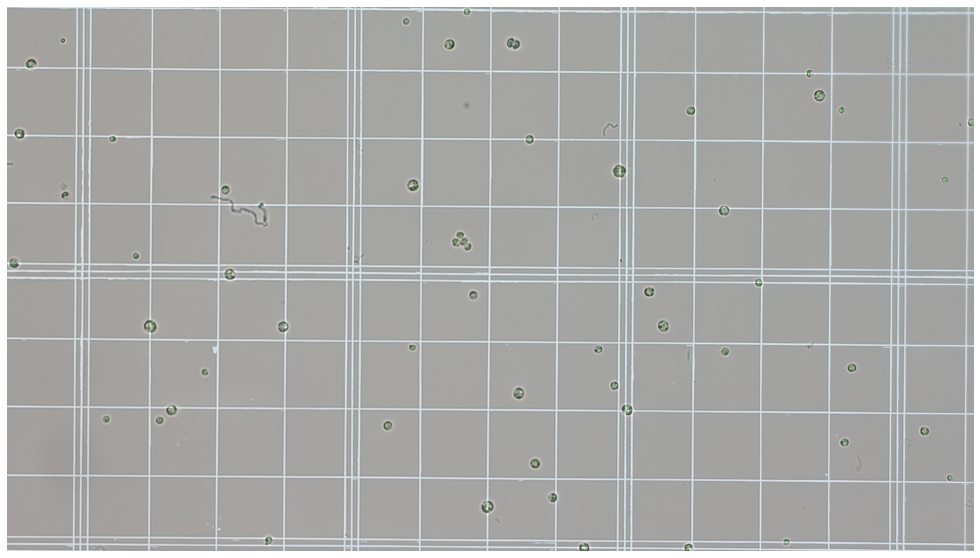

In [19]:
catIds=[1,2,3]
img = get_random_image(catIds=catIds, imgIds = list(range(1, 26)))
# load and display image
img_fpath = img_dir + img['file_name']
img_cv2 = show_image(img_fpath)

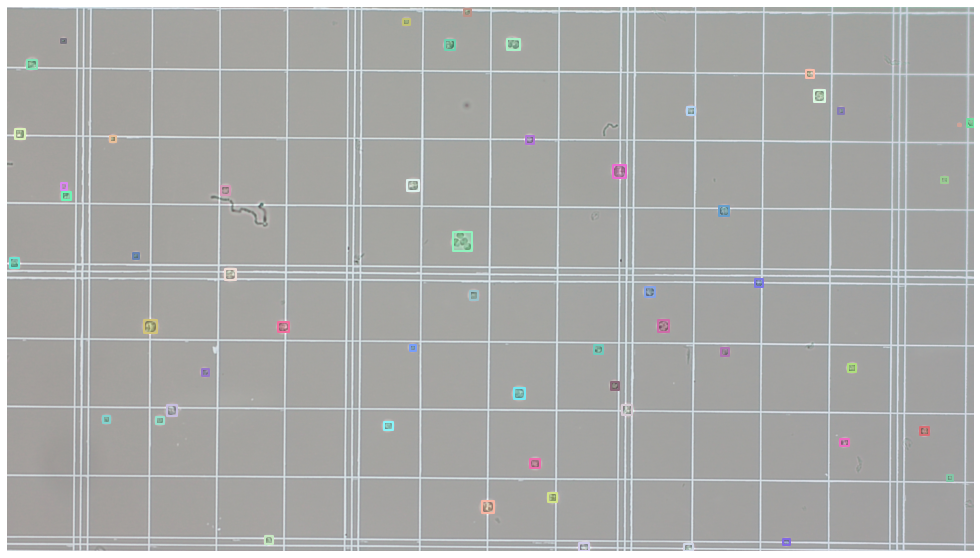

In [20]:
# load and display instance annotations
fig = plt.figure(figsize=(20, 10))
plt.imshow(img_cv2); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

### Random image with cell accumulations annotated

In [21]:
imgIds = coco.getImgIds(catIds=[2,3]);
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 76-100 revised/images/88.jpg


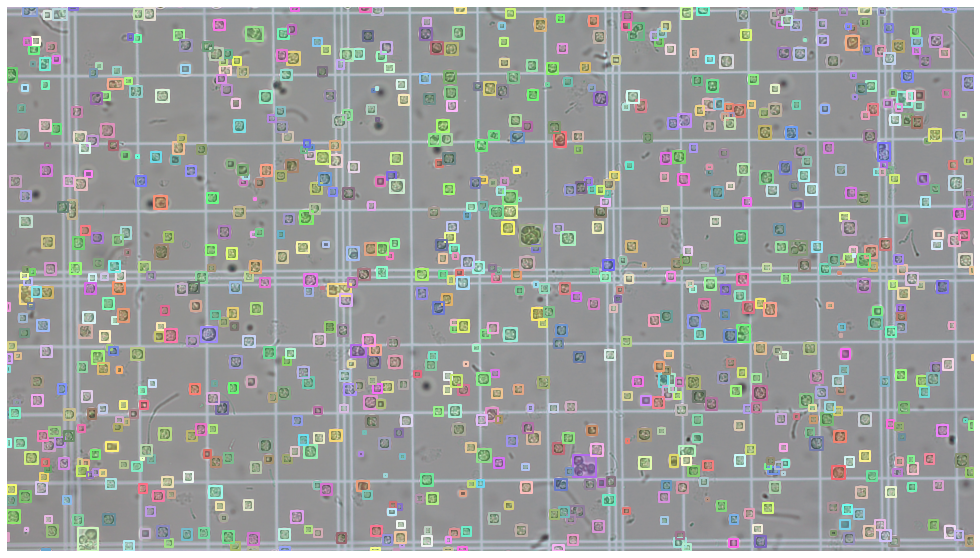

In [22]:
# load and display instance annotations
img_fpath = img_dir + img['file_name']
print(img_fpath)
img_cv2 = cv2.imread(img_fpath)
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20, 10))
plt.imshow(img_cv2); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

## Data checks

### Annotations data

In [23]:
print("Unique file names in annotations:",len(concatenated_df['file_name'].unique()))

Unique file names in annotations: 99


In [24]:
unique_images = sorted(concatenated_df['file_name'].unique())

In [25]:
print(concatenated_df['category_name'].value_counts())

Cells                              34386
cell accumulation (large cells)      531
cell accumulation (small cells)      126
Name: category_name, dtype: int64


In [26]:
annot_cell_accu_large = concatenated_df[concatenated_df['category_id']==3]
annot_cell_accu_small = concatenated_df[concatenated_df['category_id']==2]
annot_cell_only = concatenated_df[concatenated_df['category_id']==1]

**Images containing label: cell accumulation (large cells)**

In [27]:
annot_cell_accu_large['file_name'].unique()

array(['55.jpg', '54.jpg', '53.jpg', '52.jpg', '51.jpg', '50.jpg',
       '49.jpg', '48.jpg', '47.jpg', '46.jpg', '45.jpg', '43.jpg',
       '42.jpg', '41.jpg', '39.jpg', '38.jpg', '37.jpg', '36.jpg',
       '9.jpg', '8.jpg', '24.jpg', '20.jpg', '18.jpg', '17.jpg', '16.jpg',
       '15.jpg', '13.jpg', '12.jpg', '11.jpg', '10.jpg', '35.jpg',
       '34.jpg', '33.jpg', '32.jpg', '31.jpg', '30.jpg', '29.jpg',
       '28.jpg', '74.jpg', '72.jpg', '70.jpg', '68.jpg', '67.jpg',
       '66.jpg', '65.jpg', '64.jpg', '63.jpg', '62.jpg', '61.jpg',
       '60.jpg', '58.jpg', '57.jpg', '56.jpg',
       '6 c3 from agar plate 100mL bottle d1 20x undilut.jpg',
       '4 c1 from agar plate 100mL bottle d1 20x undilut.jpg',
       '2 c0.7L d5 20x 100xdilut OD15.jpg',
       '1 c0.7L d5 20x undilut OD15.jpg', '97.jpg', '95.jpg', '91.jpg',
       '90.jpg', '88.jpg', '87.jpg', '85.jpg', '84.jpg', '83.jpg',
       '82.jpg', '81.jpg', '80.jpg', '78.jpg', '77.jpg'], dtype=object)

**Images containing label: cell accumulation (small cells)**

In [28]:
annot_cell_accu_small['file_name'].unique()

array(['43.jpg', '18.jpg', '35.jpg', '33.jpg', '75.jpg', '74.jpg',
       '73.jpg', '57.jpg', '1 c0.7L d5 20x undilut OD15.jpg', '99.jpg',
       '98.jpg', '97.jpg', '96.jpg', '95.jpg', '94.jpg', '92.jpg',
       '91.jpg', '88.jpg', '86.jpg', '85.jpg', '84.jpg', '80.jpg',
       '78.jpg', '77.jpg', '76.jpg'], dtype=object)

### Image data

**Count number of images in subdirectories**

In [35]:
filepaths

['/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 36-55 revised',
 '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 8-24 revised',
 '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 8-24 revised.zip',
 '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 36-55 revised.zip',
 '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 25-35 revised',
 '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 25-35 revised.zip',
 '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 56-75 revised',
 '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 1-7 revised',
 '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 56-75 revised.zip',
 '/polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/images 76-100 revised',
 '/polyaxon-v1-data/workspa

In [38]:
filenames = []
for dirname in filepaths:
    if not filepath.endswith('.zip'):
        print(dirname)
        img_dir_path = os.path.join(dirname,img_dir_name)
        for file in os.listdir(img_dir_path):
            filenames.append(file)
print(f'Total number of image files: {len(filenames)}')
img_dest_dir_path = os.path.join(DATA_DIR, "raw")

Total number of image files: 0


In [36]:
filenames

[]

**Copy images from subdirectories to a combined 'raw' dir**

In [33]:
for dirname in filepaths:
    if not filepath.endswith('.zip'):
        img_src_dir_path = os.path.join(dirname,img_dir_name)
        for file in os.listdir(img_src_dir_path):
            try:
                shutil.copy(os.path.join(img_src_dir_path, file), img_dest_dir_path)
            except OSError as e:
                print(f"Error occurred while copying file: {e}")

**Check if all image file names defined in annotations exist**

In [34]:
error_flag = False
for img in unique_images:
    fpath = Path(img_dest_dir_path, img)
    if fpath.exists() is False:
        error_flag = True
        print(f'Image {fpath} does not exist in directory')
if not error_flag:
    print('All image files exist')

Image /polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/raw/1 c0.7L d5 20x undilut OD15.jpg does not exist in directory
Image /polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/raw/10.jpg does not exist in directory
Image /polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/raw/100.jpg does not exist in directory
Image /polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/raw/11.jpg does not exist in directory
Image /polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/raw/12.jpg does not exist in directory
Image /polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/raw/13.jpg does not exist in directory
Image /polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/raw/14.jpg does not exist in directory
Image /polyaxon-v1-data/workspaces/kwanchet/data/life3-aut0/20220224_1032621/raw/15.jpg does not exist in directory
Image /polyaxon-v1-data/workspaces/kwanchet/da